In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs,make_moons
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from scipy.cluster.hierarchy import dendrogram,ward
from sklearn.preprocessing import StandardScaler
import mglearn
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

## 군집 알고리즘 비교와 평가

### 타겟값으로 군집 평가 

ARI /NMI: 최적의 값을 가질때 1이라는 값을 가지고, 군집이 잘 분류되지 않고 무작위로 생성되었을 떄 0이라는 값을 가짐 / 0-1 사이의 값을 가짐 

** ARI는 음수가 될 수도 있음

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
x,y = make_moons(n_samples=200,noise=0.05,random_state=0)
#데이터 수집

In [4]:
#스케일링(StandardScaler)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [5]:
#사용할 알고리즘 모델을 리스트로 만듬
al=[KMeans(n_clusters=2),AgglomerativeClustering(n_clusters=2),DBSCAN()]

In [6]:
#비교를 위해 무작위로 클러스터 할당
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0,high=2,size=len(x))

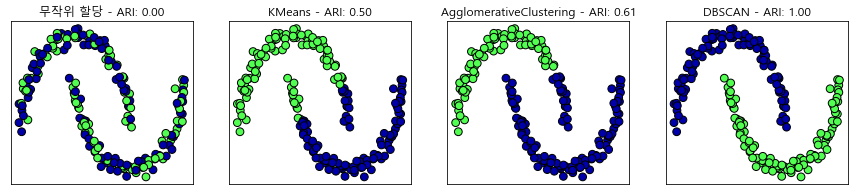

In [7]:
fig, axes= plt.subplots(1, 4, figsize= (15, 3),
                        subplot_kw= {'xticks': (), 'yticks': ()})

# 무작위로 할당한 클러스터 그리기
axes[0].scatter(x_scaled[:, 0], x_scaled[:, 1], c= random_clusters,
                cmap= mglearn.cm3, s= 60, edgecolors= 'black')
axes[0].set_title('무작위 할당 - ARI: {:.2f}'.format(adjusted_rand_score(y,
                                                     random_clusters)))
#각 클러스터 알고리즘을 비교
for ax, algorithm in zip (axes[1:], al):
    
    clusters= algorithm.fit_predict(x_scaled)
    ax.scatter(x_scaled[:, 0], x_scaled[:, 1], c= clusters,
               cmap= mglearn.cm3, s= 60, edgecolors= 'black')
    ax.set_title('{} - ARI: {:.2f}'.format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

- 이러한 형태에 데이터에 대하여 무작위 할당 클러스터는 ARI가 0, KMeans는 0.5,계층적 군집분석은 0.61, DBSCAN은 1이 나옴 = 이러한 데이터는 DBSCAN을 사용하는게 제일 좋다.

In [8]:
from sklearn.metrics import accuracy_score

#### 군집분석에서 정확도를 쓰지 않는 이유

In [9]:
cluster1 = [0,0,1,1,0]
cluster2 = [1,1,0,0,1]

print('정확도 : {:.2f}'.format(accuracy_score(cluster1,cluster2)))
print('ARI : {:.2f}'.format(adjusted_rand_score(cluster1,cluster2)))

정확도 : 0.00
ARI : 1.00


### 실루엣 지수
- 그렇게 잘 작동하는 지표는 아님
- 클러스터의 밀집 정도를 계산해줘서 값이 높을수록 좋고 최대점수 1을 가짐
- 복잡할 때 밀집도를 활용한 평가는 잘 맞지 않음
- 1과 -1 사이의 값을 가짐
- -1일때는 잘못 군집을 분류, 0일때는 군집 중첩 의심, 1일때는 군집이 잘 분류되었다.

In [10]:
from sklearn.metrics.cluster import silhouette_score

In [11]:
x,y = make_moons(n_samples=200,noise=0.05,random_state=0)
#데이터 수집

In [12]:
#스케일링
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

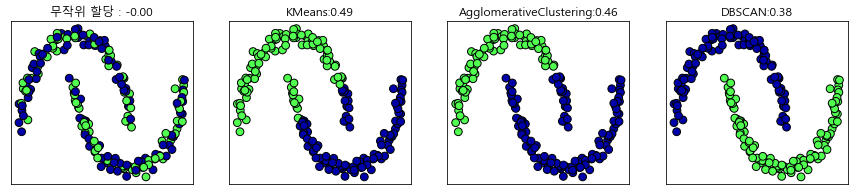

In [13]:
fig,axes = plt.subplots(1,4,figsize=(15,3),
                       subplot_kw={'xticks':(),'yticks':()})

#클러스터를 랜덤으로 할당해주는 코드
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0,high=2,size=len(x))

#무작위 클러스터 그리기
axes[0].scatter(x_scaled[:,0],x_scaled[:,1],
                c=random_clusters,cmap=mglearn.cm3,s=60,edgecolors='black')
axes[0].set_title('무작위 할당 : {:.2f}'.format(silhouette_score(x_scaled,
                                                           random_clusters)))

#사용 알고리즘 리스트화
al=[KMeans(n_clusters=2),AgglomerativeClustering(n_clusters=2),DBSCAN()]

#각 알고리즘 시각화
for ax, algorithm in zip(axes[1:],al):
    clusters = algorithm.fit_predict(x_scaled)
    ax.scatter(x_scaled[:,0],x_scaled[:,1],c=clusters,cmap=mglearn.cm3,
              s=60,edgecolors='black')
    ax.set_title('{}:{:.2f}'.format(algorithm.__class__.__name__,
                                   silhouette_score(x_scaled,clusters)))

실루엣 지수가 높다고 하더라도 유의미하다라고 확정적으로 판단하기는 어렵다.

### 얼굴 데이터셋으로 군집 알고리즘 비교

In [14]:
from sklearn.datasets import fetch_lfw_people

In [15]:
#이미지 데이터를 사용 가능하게 전처리해주는 과정
people = fetch_lfw_people(min_faces_per_person=20,resize=0.7)
image_shape=people.images[0].shape

mask=np.zeros(people.target.shape,dtype=bool)

for target in np.unique(people.target):
    mask[np.where(people.target==target)[0][:50]]=1
    
x_people = people.data[mask]
y_people = people.target[mask]

#흑백 이미지의 픽셀은 0~255이기 때문에 255로 나눠 0~1사이의 값을 가지게 만듬 
x_people = x_people/255

In [16]:
#차원축소
from sklearn.decomposition import PCA

pca = PCA(n_components=100,whiten=True,random_state=0)
#모델 선정
x_pca = pca.fit_transform(x_people)
#모델 학습, 변환(차원축소)

#### DBSCAN

In [17]:
dbscan = DBSCAN(min_samples=3) 
#모델 선정
labels = dbscan.fit_predict(x_pca) 
#모델 학습,예측(군집화)
print('고유한 레이블: ',np.unique(labels))

고유한 레이블:  [-1]


In [18]:
dbscan=DBSCAN(min_samples=3,eps=15) 
#모델 선정(군집별 최소샘플=3, epsilon=15)
labels = dbscan.fit_predict(x_pca) 
#모델 학습,예측(군집화)
print('고유한 레이블: ',np.unique(labels)) #노이즈 데이터 생김

고유한 레이블:  [-1  0]


In [19]:
print('클러스터별 포인트 수 :',np.bincount(labels+1))
#noise point가 32개 생겼다.

클러스터별 포인트 수 : [  32 2031]


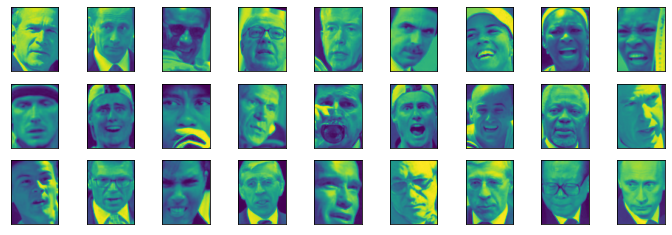

In [20]:
noise = x_people[labels == -1]

fig,axes = plt.subplots(3,9,subplot_kw={'xticks':(),'yticks':()},
                       figsize=(12,4))

#사람들의 얼굴을 뽑기 위한 for문
for image, ax in zip(noise,axes.ravel()):
    ax.imshow(image.reshape(image_shape),vmin=0,vmax=1)

plt.show()

In [21]:
for eps in [1,3,5,7,9,11,13]:
    print('\neps=',eps)
    dbscan = DBSCAN(eps=eps,min_samples=3)
    labels = dbscan.fit_predict(x_pca)
    print('클러스터 수:',len(np.unique(labels)))
    print('DBSCAN 클러스터 크기:',np.bincount(labels+1))
    
#엡실론의 크기를 바꾸어 가면서 데이터를 확인하는것
#이상치 검출


eps= 1
클러스터 수: 1
DBSCAN 클러스터 크기: [2063]

eps= 3
클러스터 수: 1
DBSCAN 클러스터 크기: [2063]

eps= 5
클러스터 수: 1
DBSCAN 클러스터 크기: [2063]

eps= 7
클러스터 수: 14
DBSCAN 클러스터 크기: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps= 9
클러스터 수: 4
DBSCAN 클러스터 크기: [1307  750    3    3]

eps= 11
클러스터 수: 2
DBSCAN 클러스터 크기: [ 413 1650]

eps= 13
클러스터 수: 2
DBSCAN 클러스터 크기: [ 120 1943]


#### K-Means

In [22]:
n_clusters = 10

km = KMeans(n_clusters=n_clusters, random_state=0)
#모델 선정
labels_km=km.fit_predict(x_pca)
#모델 학습 및 예측(군집화)
print('k-means 클러스터 크기:',np.bincount(labels_km))

k-means 클러스터 크기: [155 175 238  75 358 257  91 219 323 172]


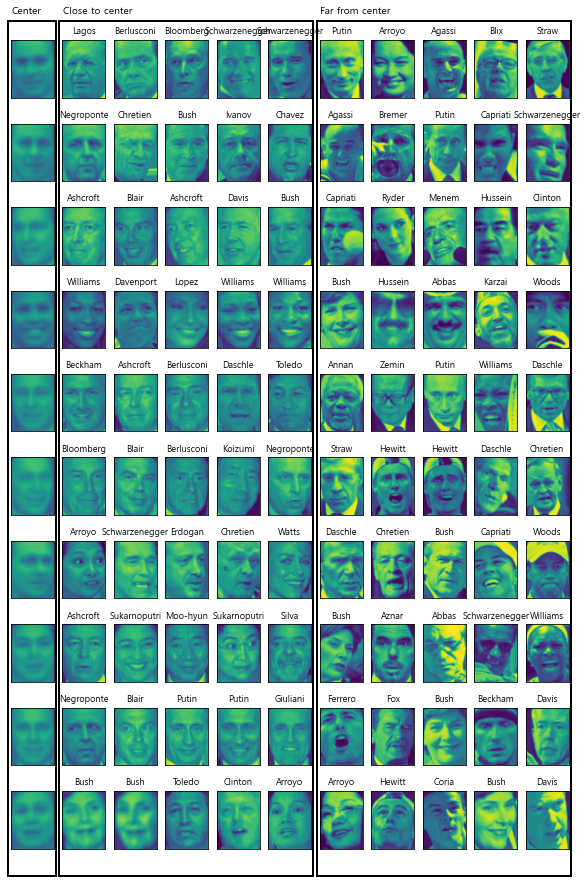

In [23]:
#시각화
mglearn.plots.plot_kmeans_faces(km,pca,x_pca,
                                x_people,y_people,people.target_names)

#### 계층적 군집으로 얼굴 분석

##### sklearn

In [24]:
agg = AgglomerativeClustering(n_clusters=10)
#모델 선정
labels_agg = agg.fit_predict(x_pca)
#모델 학습 및 예측(군집화)

print('계층적 군집의 클러스터 크기:',np.bincount(labels_agg))

계층적 군집의 클러스터 크기: [169 660 144 329 217  85  18 261  31 149]


In [25]:
print('ARI : {:.2f}'.format(adjusted_rand_score(labels_agg,labels_km)))
#ARI값 산출
#이 알고리즘으로 사진 데이터를 산출하는것은 적합하지 않다.(ARI값 낮음)

ARI : 0.09


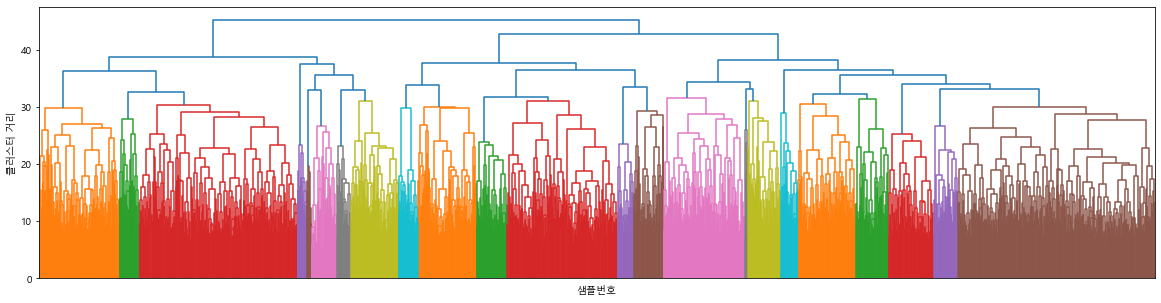

In [26]:
linkage_array = ward(x_pca) #클러스터 사이의 거리가 담겨져있음.

#시각화
plt.figure(figsize=(20,5))
dendrogram(linkage_array,p=7,no_labels=True)
plt.xlabel('샘플번호')
plt.ylabel('클러스터 거리')
plt.show()

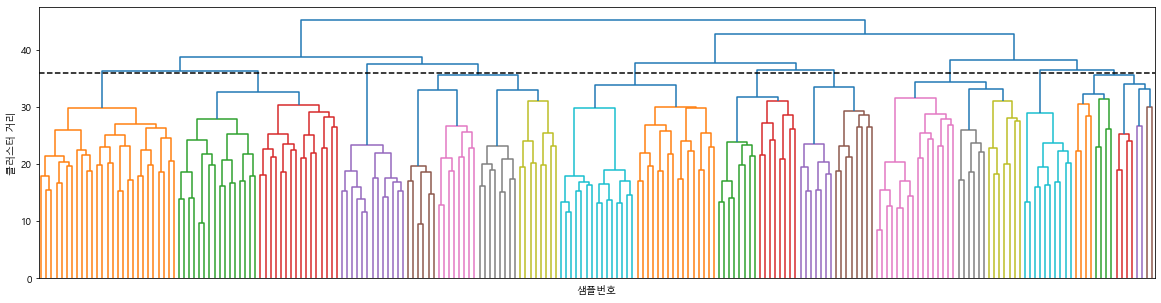

In [27]:
linkage_array = ward(x_pca) #클러스터 사이의 거리가 담겨져있음.

#시각화
plt.figure(figsize=(20,5))
dendrogram(linkage_array,p=7,truncate_mode='level', no_labels=True)
plt.xlabel('샘플번호')
plt.ylabel('클러스터 거리')

ax = plt.gca()
bounds=ax.get_xbound()
ax.plot(bounds,[36,36],'--',c='k')